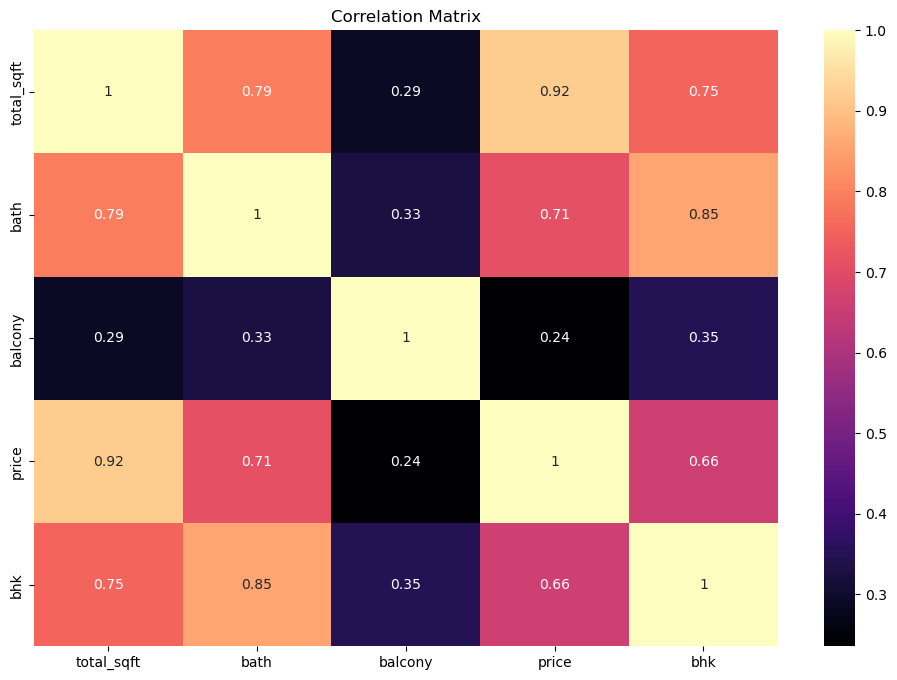

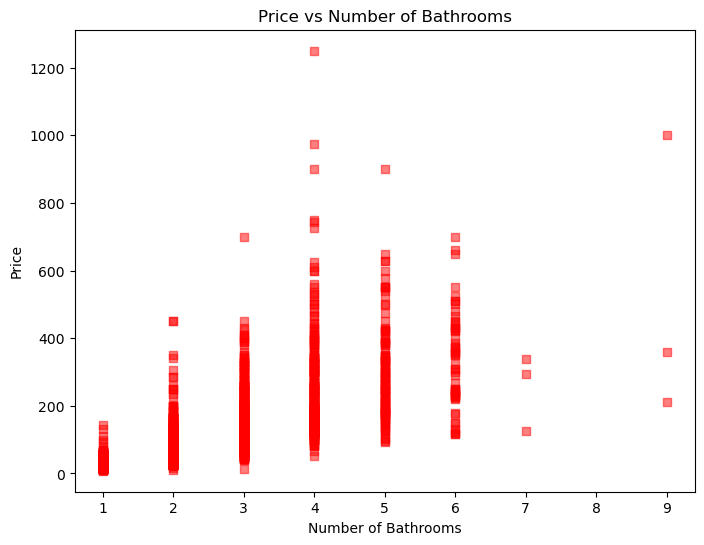

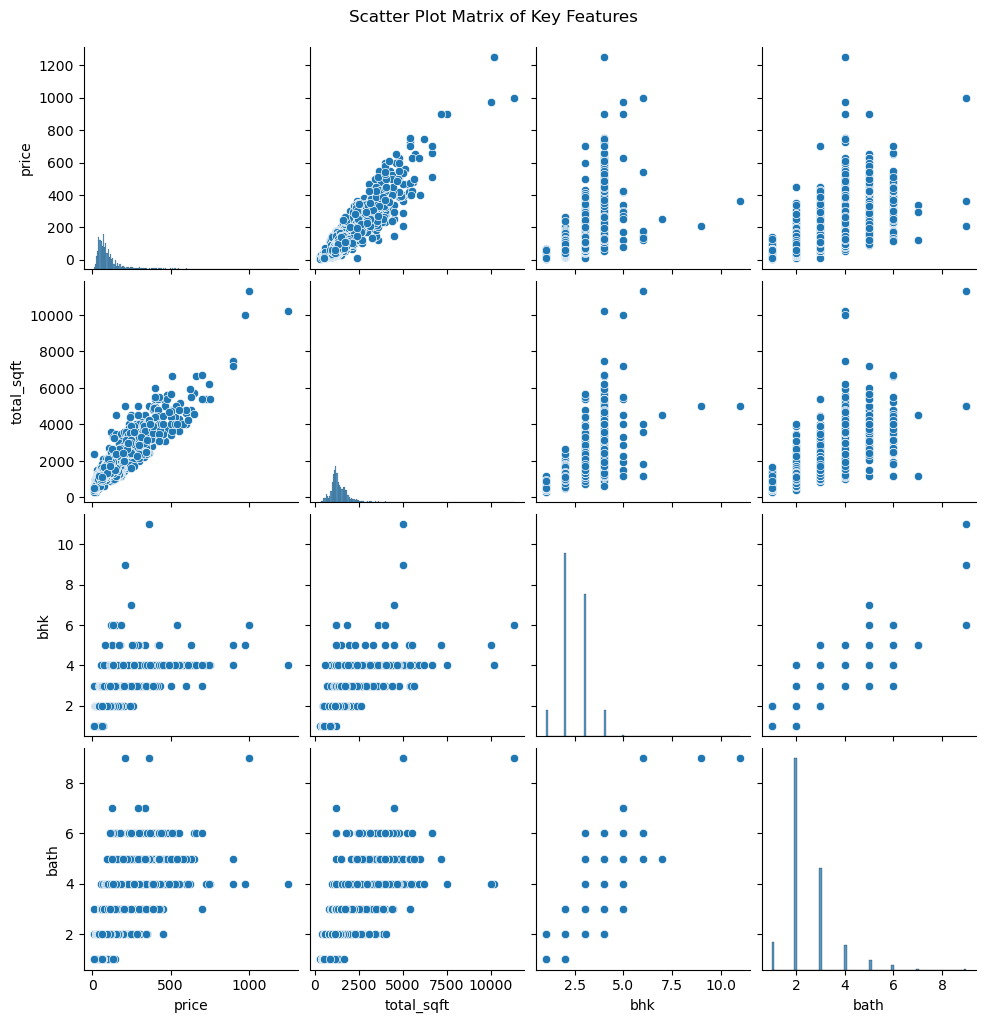

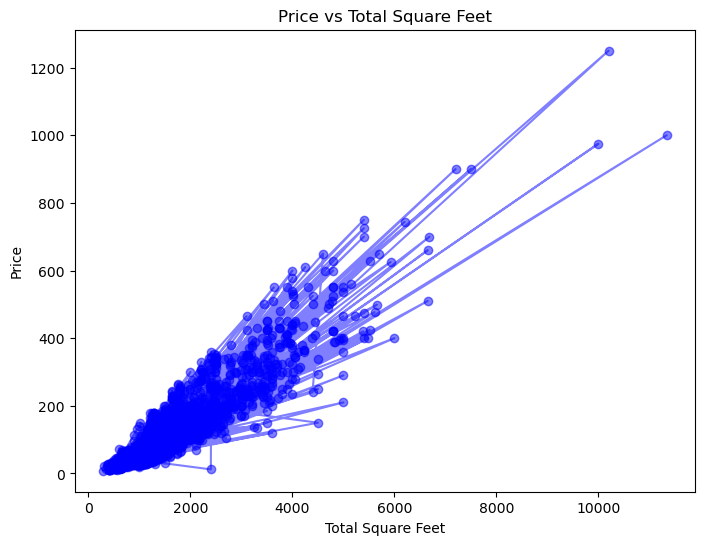

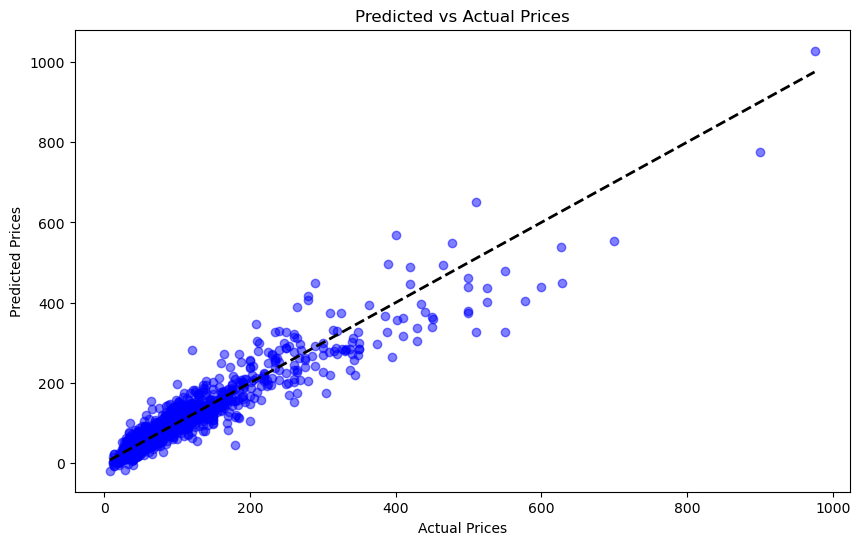

18.910865594237283
908.0862392795938
30.134469288168887


/var/folders/63/gfgyqz0s19d0np85bch0z7k00000gn/T/ipykernel_41821/2785430182.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


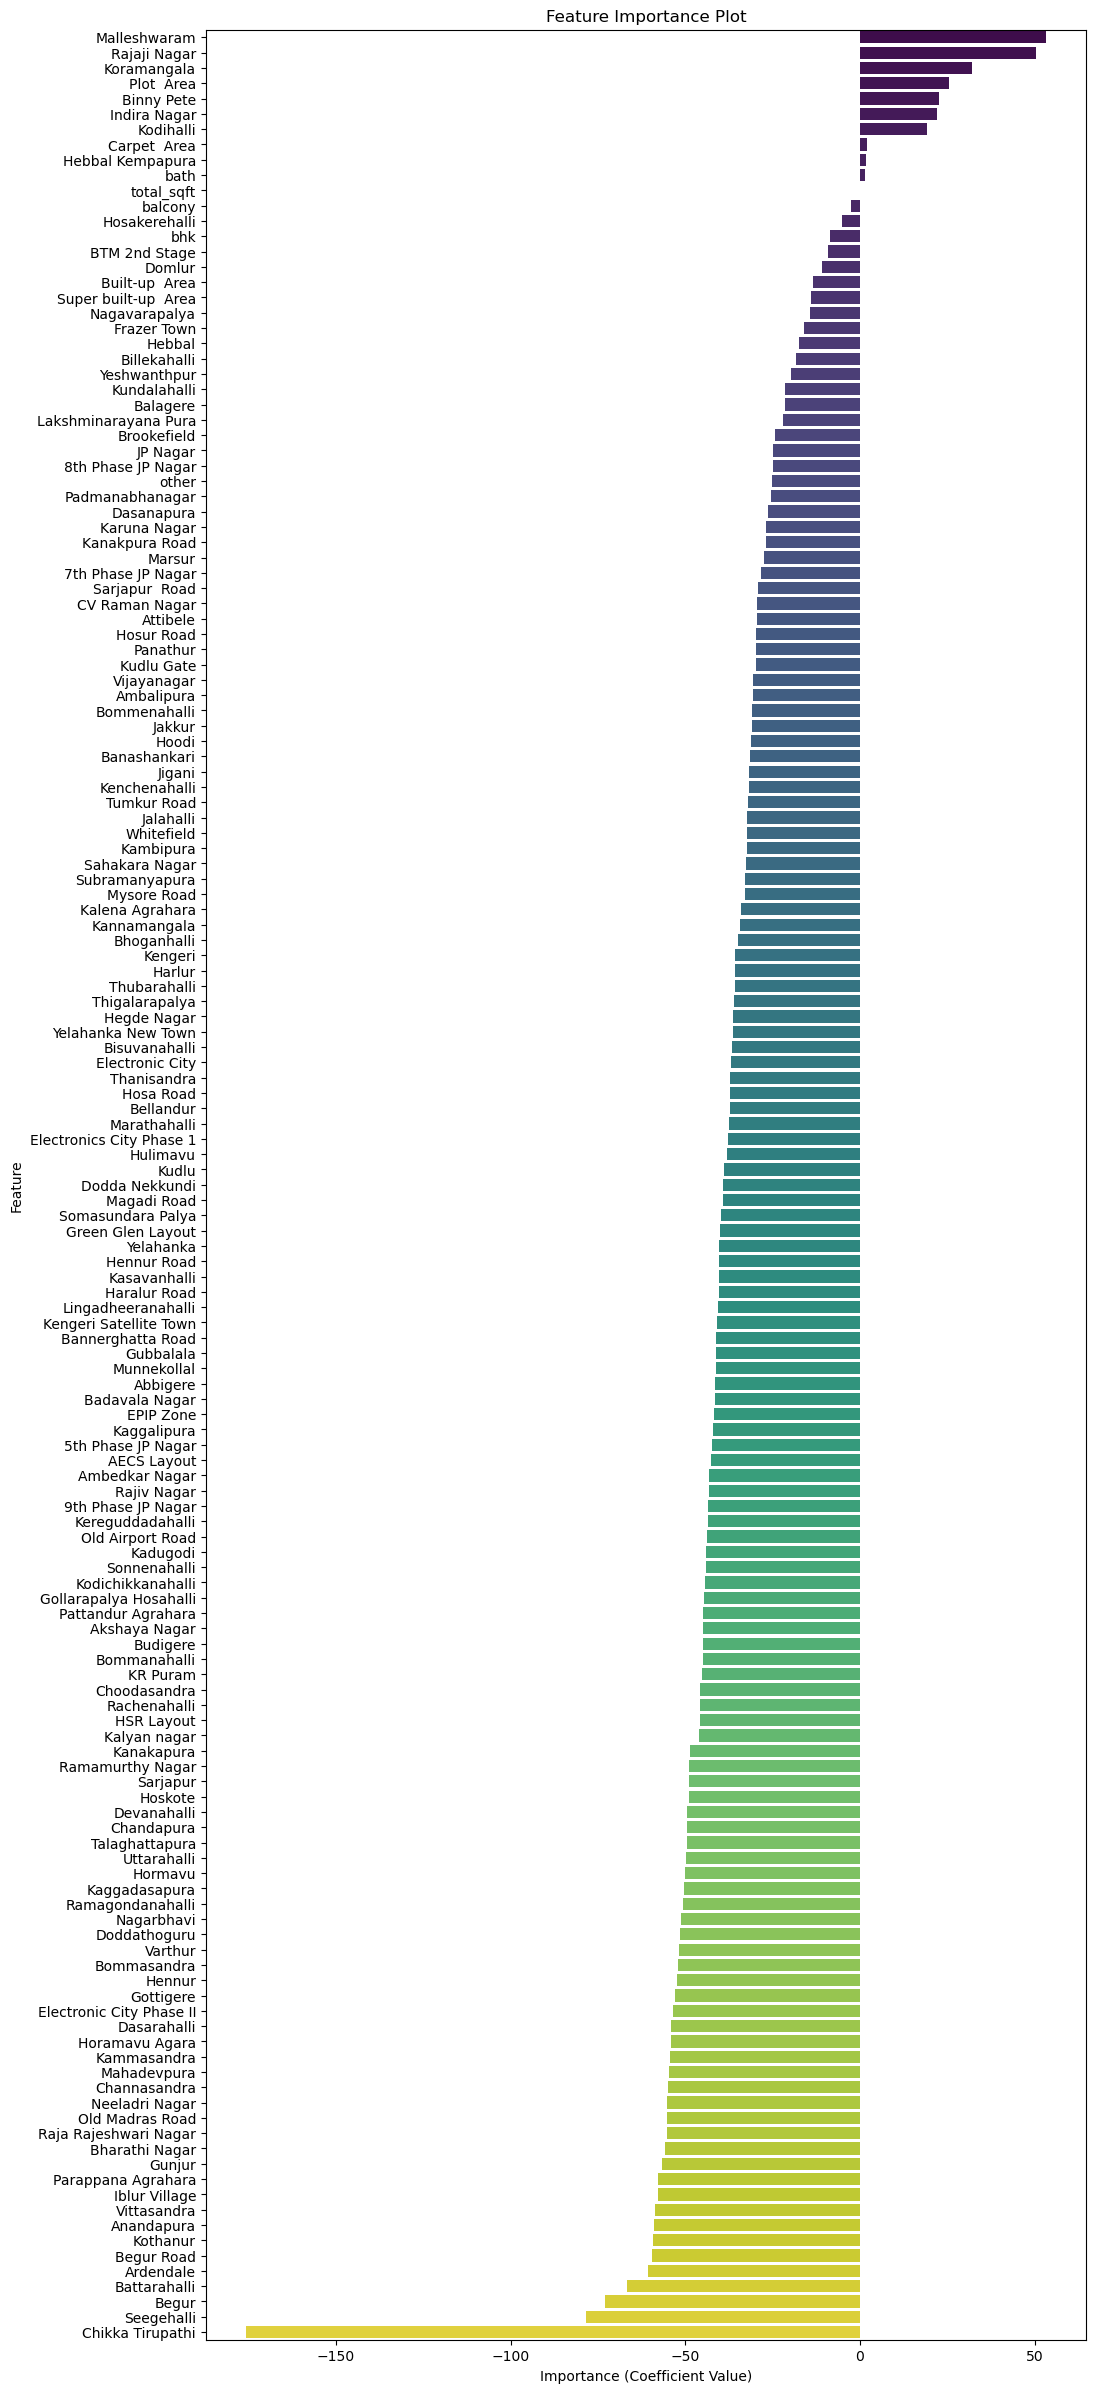

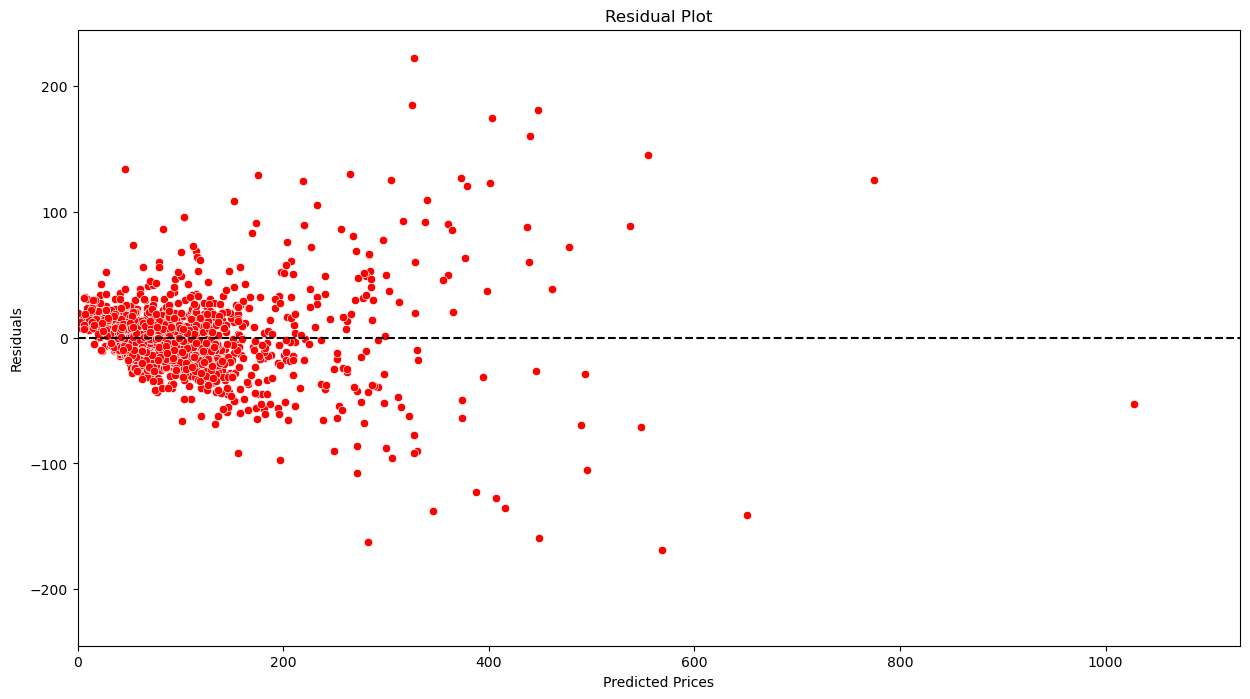

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


227.80006850067605

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("House_Data.csv")
data.head()

data.shape

data.describe

data.isnull().sum()

#Data clean: handle null values
data = data.dropna()

data.area_type.unique()

#drop availability because it's not required 
data = data.drop('availability',axis=1)

data.location.unique()

len(data.location.unique())

location_count = data.groupby('location').size().sort_values(ascending=False)
location_count

len(location_count[location_count<=10])

location_less_10 = location_count[location_count<=10]

#if the location have less than 10 or 10 houses than that location are known as other location
data.location = data.location.apply(lambda x: 'other' if x in location_less_10 else x)

len(data.location.unique())

data['bhk'] = data['size'].apply(lambda x: int(x.split(' ')[0]))
data.bhk.unique() 

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

data.total_sqft = data.total_sqft.apply(convert_sqft_to_num)
data = data[data.total_sqft.notnull()]
data.head()

#drop society column because it's not required
data = data.drop('society',axis=1)

data.head()

#create new column price_sqft that contain price per sqft
data['price_sqft'] = data.price*100000/data.total_sqft

#remove outlier using standard deviation
upper_limit = data.price_sqft.mean() + data.price_sqft.std()
lower_limit = data.price_sqft.mean() - data.price_sqft.std()
data = data[data.price_sqft<upper_limit] 
data = data[data.price_sqft > lower_limit]

#remove 2BHK house that price per sqft is less than the mean of 1bhk house price
def remove_bhk_outliers(data):
    exclude_indices = np.array([])
    for location, location_df in data.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_sqft),
                'std': np.std(bhk_df.price_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_sqft<(stats['mean'])].index.values)
    return data.drop(exclude_indices,axis='index')
data = remove_bhk_outliers(data)

data = data.drop('price_sqft',axis=1)

#apply one hot encoding in location column
dummies = pd.get_dummies(data.location)
location_cat = pd.get_dummies(data.location)
dummies.head()

plt.figure(figsize=(12, 8))
numeric_data = data.select_dtypes(include=[np.number])  # Select only numeric columns
corr_matrix = numeric_data.corr()

sns.heatmap(corr_matrix, annot=True, cmap='magma')
plt.title('Correlation Matrix')
plt.show()



data = pd.concat([data,dummies.drop('1st Phase JP Nagar',axis='columns')],axis='columns')
data.head()

# Scatter plot between price and bath
plt.figure(figsize=(8, 6))
plt.scatter(data.bath, data.price, c='r', marker='s', alpha=0.5)
plt.title('Price vs Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')
plt.show()


# Select numeric columns for visualization
numeric_data = data[['price', 'total_sqft', 'bhk', 'bath']]

# Pairplot for scatter plots between all numeric columns
sns.pairplot(numeric_data)
plt.suptitle('Scatter Plot Matrix of Key Features', y=1.02)
plt.show()


# Scatter plot between price and total_sqft
plt.figure(figsize=(8, 6))
plt.plot(data.total_sqft, data.price, c='b', marker='o', alpha=0.5)
plt.title('Price vs Total Square Feet')
plt.xlabel('Total Square Feet')
plt.ylabel('Price')
plt.show()

#apply one hot encoding in area column
dummies = pd.get_dummies(data.area_type)
dummies.head()

data = pd.concat([data,dummies],axis='columns')
data.head()

data = data.drop(['location','size','area_type'] , axis=1)

data.head()

#split data into dependent feature & independent feature
X = data.drop('price',axis=1)

y=data['price']

#split data into train-test split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
regressor = cross_val_score(LinearRegression(), X, y, cv=cv)
regressor

np.average(regressor)

from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(X,y,test_size=0.3)

model = LinearRegression()
model.fit(x_train , y_train)

y_pred = model.predict(x_test)


# Plot for Predicted vs Actual Prices
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted prices
plt.scatter(y_test, y_pred, c='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual Prices')

plt.show()


from sklearn import metrics
print(metrics.mean_absolute_error(y_test,y_pred))
print(metrics.mean_squared_error(y_test,y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

# Feature Importance Plot
feature_importance = model.coef_
feature_names = X.columns

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Create visualizations
plt.figure(figsize=(25, 30))

# Feature Importance Plot
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Plot')
plt.xlabel('Importance (Coefficient Value)')
plt.ylabel('Feature')




# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(15, 8))
sns.scatterplot(x=y_pred, y=residuals, color='r')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residual Plot')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.xlim([0, max(y_pred) * 1.1])
plt.ylim([-max(abs(residuals)) * 1.1, max(abs(residuals)) * 1.1])


plt.show()

#save the model
import pickle
with open('model.pkl', 'wb') as fh:
   pickle.dump(model, fh)

cat = data.drop(['price'] , axis=1)
index_dict = dict(zip(cat.columns,range(cat.shape[1])))
with open('cat', 'wb') as fid:
    pickle.dump(index_dict, fid,2)  

#save the column name
location_list = list(zip(location_cat.columns,range(cat.shape[1])))

with open('location_cat', 'wb') as fid:
    pickle.dump(location_list, fid,2)  

def predict(location,area,size,bath,balcony,total_sqft):
    output = np.zeros(151)
    output[0] = total_sqft
    output[1] = bath
    output[2] = balcony
    output[3] = size
    
    result_location = location
    if result_location not in location_cat:
        output[146] = 1
    else:
        output[index_dict[str(location)]] = 1
    
    return model.predict([output])[0]

#(location , area_type , size , bath , balcony , total_sqft)


predict('Yeshwanthpur' , 'Carpet Area' , 3 , 3 , 2 ,3560)

predict('Yelahanka New Town' , 'Carpet Area' , 3 , 4 , 2 ,4000)


predict('rajkot' , 'Carpet Area' , 3 , 3 , 3 ,2550)

In [2]:
predict('Yelahanka','Carpet Area', 3, 3, 2 ,3000)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


262.9991348668997

In [3]:
predict('rajkot' , 'Carpet Area' , 3 , 3 , 3 ,2550)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


227.80006850067605